### Importing modules

In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

#### Data preprocessing

In [2]:
train=pd.read_csv('train.csv ')

In [3]:
train.head()

,id,transaction time,current bank amount,last bank amount,time taken (seconds),most recent bank amount,account type,marital_status,age,occupation,credit card type,account source verification,transaction source method,account destination verification,fradulent
0,acus0,2016-10-05T01:44:58,43671,1151263,2299,348764,saving,married,46,musician,master,True,False,True,0
1,acus1,2015-01-14T15:05:07,7442,1062843,4553,225114,current,single,64,accounting,master,True,False,False,0
2,acus2,2016-10-28T13:44:58,40102,48042,1493,420486,current,married,41,farmer,master,True,True,True,0
3,acus3,2016-11-20T15:05:32,61024,1441746,544,239663,current,unknown,66,clergy,master,True,True,True,0
4,acus4,2015-09-01T16:11:57,22867,510656,4581,432337,current,married,78,accounting,verve,False,False,True,1


In [4]:
null_column=train.isnull().sum()

In [5]:
print(null_column)

id                                  0
transaction time                    0
current bank amount                 0
last bank amount                    0
time taken (seconds)                0
most recent bank amount             0
account type                        0
marital_status                      0
age                                 0
occupation                          0
credit card type                    0
account source verification         0
transaction source method           0
account destination verification    0
fradulent                           0
dtype: int64

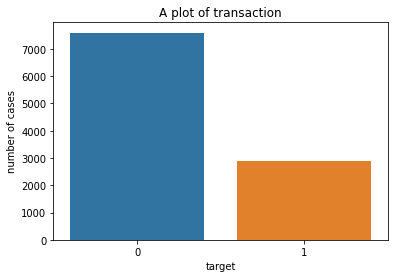

In [7]:
sns.countplot(train['fradulent'])
plt.title('A plot of transaction')
plt.xlabel('target')
plt.ylabel('number of cases')
plt.show()

In [11]:
train['hour']=train['transaction time'].str.split('T',expand=True)[1].str.split(':',expand=True)[0]
train['year']=train['transaction time'].str.split('-',expand=True)[0]

In [13]:
train['account type'].value_counts(ascending=False)

current    8984
saving     1509
Name: account type, dtype: int64

In [14]:
encode={'account type':{'saving':0,'current':1},
        
       'credit card type':{'master':0,'verve':1},
        
       'occupation':{'clergy':0,'accounting':1,'lecturer':2,'banking':3,
                     'doctor':4,'farmer':5,'lawyer':6, 'musician':7},
        
        'marital_status':{'married':0,'single':1,'unknown':2},
        
        'year':{'2014':0,'2015':1,'2016':2,'2017':3}
       
       }

In [15]:
train=train.replace(encode)

In [16]:
train.set_index(['id'],inplace=True,drop=True)
train.drop(['transaction time'],axis=1,inplace=True)

In [17]:
X=train.drop(['fradulent'],axis=1)
y=train['fradulent']

### Modeling

In [18]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler()
X=std.fit_transform(X)

In [19]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [21]:
gb=GradientBoostingClassifier(random_state=0,learning_rate=0.1)
gb.fit(x_train,y_train)

GradientBoostingClassifier(random_state=0)

In [22]:
params = {'n_estimators': 1000,
          'max_depth': 3,
        
         'learning_rate':0.1,
         }

gb=GradientBoostingClassifier(**params)
gb.fit(x_train,y_train)

GradientBoostingClassifier(n_estimators=1000)

### Prediction

In [23]:
y_pred=gb.predict(x_test)

In [24]:
gb.score(x_train,y_train)

0.9460328806290207

In [25]:
confusion_matrix(y_test,y_pred)

array([[1240,  292],
       [ 331,  236]], dtype=int64)

In [26]:
roc_auc=roc_auc_score(y_test,y_pred)

In [27]:
print(roc_auc)

0.6128126136829357

In [32]:
def to_labels(pos_probs,threshold):
    return (pos_probs >=threshold).astype('int')

In [31]:
def thresh(probs,threshold):    
    probs[probs>threshold]=1
    probs[probs<=threshold]=0
    return (probs)

In [37]:
def threshold(model,pred):
    probs=model.predict_proba(pred)[:,1]
    threshold=np.arange(0,1,0.0001)
    scores=[roc_auc_score(y_test,to_labels(probs,t))for t in threshold]
    ix=np.argmax(scores)
    print('roc_auc-score=%.5f'%(scores[ix]))
    return (threshold[ix])

In [38]:
model_threshold=threshold(gb,x_test)

roc_auc-score=0.79357


#### Saving model

In [28]:
with open('pred','wb') as file:
    pickle.dump(gb,file)